### Word2Vec using MXNet Gluon API

The goal of this notebook is to show Word2Vec Skipgram implementation with Negative Sampling to train word vectors on the text8 dataset.    

Please note that python based deep learning framworks are not suitable for Word2Vec. This is maily due to python's limitations that force the data iterator to be single threaded and does not allow asynchronous SGD - all CPU cores cannot do the optimization in parallel to each other as done in the original Word2Vec C implementation.    

This notebook is for demo purposes only - highlighting the features of new Gluon API that makes it very easy to prototype complex models with custom losses.

In [15]:
import time
import numpy as np
import logging
import sys, random, time, math
import mxnet as mx
from mxnet import nd
from mxnet import gluon
from mxnet.gluon import Block, nn, autograd
import cPickle
from sklearn.preprocessing import normalize

Download the text8 dataset

In [ ]:
!wget http://mattmahoney.net/dc/text8.zip -O text8.gz && gzip -d text8.gz -f

Read the text8 file to build vocabulary, word-to-word_index and word_index-to-word mappings.

In [16]:
buf = open("text8").read()
tks = buf.split(' ')
vocab = {}
wid_to_word = ["NA"]
freq = [0] # Store frequency of all tokens.
data = [] # Store word indices
for tk in tks:
    if len(tk) == 0:
        continue
    if tk not in vocab:
        vocab[tk] = len(vocab) + 1
        freq.append(0)
        wid_to_word.append(tk)
    wid = vocab[tk]
    data.append(wid)
    freq[wid] += 1
negative = [] # Build this table for negative sampling for words from a Unigram distribution.
for i, v in enumerate(freq):
    if i == 0 or v < 5:
        continue
    v = int(math.pow(v * 1.0, 0.75))
    negative += [i for _ in range(v)]

**Define the constrants / hyperparameters. Set the context to GPU **


In [18]:
VOCAB_SIZE = len(wid_to_word)
BATCH_SIZE = 512
WORD_DIM = 100
NEGATIVE_SAMPLES = 5

# Preferably use GPU for faster training.
ctx = mx.gpu()

In [410]:
class DataBatch(object):
    def __init__(self, data, label):
        self.data = data
        self.label = label

** Avoid running the cell below this comment for demo. It takes around 20 min to generate training data for 1 epoch using Python. This is one of the primary reasons why Word2Vec is not suitable for Python based deep learning frameworks. **  
We have already generated the training dataset and uploaded it to S3. Please use the next cell to download the dataset.

In [430]:
class Word2VecDataIterator(mx.io.DataIter):
    def __init__(self,batch_size=512, negative_samples=5, window=5):
        super(Word2VecDataIterator, self).__init__()
        self.batch_size = batch_size
        self.negative_samples = negative_samples
        self.window = window
        self.data, self.negative, self.vocab, self.freq = (data, negative, vocab, freq)

    @property
    def provide_data(self):
        return [('contexts', (self.batch_size, 1))]

    @property
    def provide_label(self):
        return  [('targets', (self.batch_size, self.negative + 1))]

    def sample_ne(self):
        return self.negative[random.randint(0, len(self.negative) - 1)]

    def __iter__(self):
        center_data = []
        targets = []
        result = 0
        for pos, word in enumerate(self.data):
            boundary = random.randint(1,self.window)  # `b` in the original word2vec code
            for index in range(-boundary, boundary+1):
                if (index != 0 and pos + boundary >= 0 and pos + boundary < len(self.data)):
                    center_word = word
                    context_word = self.data[pos + index]
                    if center_word != context_word:
                        targets_vec = []
                        center_data.append([word])
                        targets_vec.append(context_word)
                        while len(targets_vec) < self.negative_samples + 1:
                            w = self.sample_ne()
                            if w != word:
                                targets_vec.append(w)
                        targets.append(targets_vec)

            # Check if batch size is full
            if len(center_data) > self.batch_size:
                data_all = [mx.nd.array(center_data[:self.batch_size])]
                label_all = [mx.nd.array(targets[:self.batch_size])]
                yield DataBatch(data_all, label_all)
                center_data = center_data[self.batch_size:]
                targets = targets[self.batch_size:]

data_iterator = Word2VecDataIterator(batch_size=BATCH_SIZE,
                                     negative_samples=NEGATIVE_SAMPLES,
                                     window=5)   
all_batches = []
for batch in data_iterator:
    all_batches.append(batch)
cPickle.dump(all_data, open('all_batches.p', 'wb')) 

** Download and read the pickled training dataset **

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/gsaur-dev/input.p
all_batches = cPickle.load(open('input.p', 'rb'))

### Word2Vec training
Word2vec represents each word $w$ in a vocabulary $V$ of size $T$ as a low-dimensional dense vector $v_w$ in an embedding space $\mathbb{R}^D$. It attempts to learn the continuous word vectors $v_w$, $\forall w \in V$ , from a training corpus such that the spatial distance between words then describes the similarity between words, e.g., the closer two words are in the embedding space, the more similar they are semantically and syntactically.  

The skipgram architecture tries to predict the context given a word. The problem of predicting context words is framed as a set of independent binary classification tasks. Then the goal is to independently predict the presence (or absence) of context words. For the word at position $t$ we consider all context words as positive examples and sample negatives at random from the dictionary. For a chosen context position $c$, using the binary logistic loss, we obtain the following negative log-likelihood:

$$ \log (1 + e^{-s(w_t, w_c)}) +  \sum_{n \in \mathcal{N}_{t,c}}^{}{\log (1 + e^{s(w_t, n)})}$$

where $w_t$ is a center word, $w_c$ is a context word, $\mathcal{N}_{t,c}$ is a set of negative examples sampled from the vocabulary. By denoting the logistic loss function $l : x \mapsto \log(1 + e^{-x})$, we can re-write the objective as:

$$ \sum_{t=1}^{T}{ \sum_{c \in C_t}^{}{ \big[ l(s(w_t, w_c))} + \sum_{n \in \mathcal{N}_{t,c}}^{}{l(-s(w_t, n))}   \big]} $$

where $s(w_t, w_c) = u_{w_t}^T v_{w_c}$


In [637]:
class Model(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Model, self).__init__(**kwargs)
        with self.name_scope():
            
            # Embedding for input words with dimensions VOCAB_SIZE X WORD_DIM
            self.center = nn.Embedding(input_dim=VOCAB_SIZE,
                                       output_dim=WORD_DIM,
                                       weight_initializer=mx.initializer.Uniform(1.0/WORD_DIM))
            
            # Embedding for output words with dimensions VOCAB_SIZE X WORD_DIM
            self.target = nn.Embedding(input_dim=VOCAB_SIZE,
                                       output_dim=WORD_DIM,
                                       weight_initializer=mx.initializer.Zero())

    def hybrid_forward(self, F, center, targets, labels):
        """
        Returns the word2vec skipgram with negative sampling network.
        :param F: F is a function space that depends on the type of other inputs. If their type is NDArray, then F will be mxnet.nd otherwise it will be mxnet.sym
        :param center: A symbol/NDArray with dimensions (batch_size, 1). Contains the index of center word for each batch.
        :param targets: A symbol/NDArray with dimensions (batch_size, negative_samples + 1). Contains the indices of 1 target word and `n` negative samples (n=5 in this example)
        :param labels: A symbol/NDArray with dimensions (batch_size, negative_samples + 1). For 5 negative samples, the array for each batch is [1,0,0,0,0,0] i.e. label is 1 for target word and 0 for negative samples
        :return: Return a HybridBlock object
        """
        center_vector = self.center(center)
        target_vectors = self.target(targets)
        pred = F.broadcast_mul(center_vector, target_vectors)
        pred = F.sum(data = pred, axis = 2)
        sigmoid = F.sigmoid(pred)
        loss = F.sum(labels * F.log(sigmoid) + (1 - labels) * F.log(1 - sigmoid), axis=1)
        loss = loss * -1.0 / BATCH_SIZE
        loss_layer = F.MakeLoss(loss)
        return loss_layer

model = Model()
model.initialize(ctx=ctx)
model.hybridize() # Convert to a symbolic network for efficiency.

** Use a large learning rate since batch size is large - 512 in this example. In the original word2vec C implementation, stochastic gradient descent is used i.e. batch_size = 1. However, batch_size = 1 for deep learning frameworks slows down the training drastically, therefore a larger batch size is used. Larger the batch size, faster the training and slower the convergence. **

In [638]:
trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate':4,'clip_gradient':5})

In [ ]:
labels = nd.zeros((BATCH_SIZE, NEGATIVE_SAMPLES+1), ctx=ctx)
labels[:,0] = 1
start_time = time.time()
epochs = 5
for e in range(epochs):
    moving_loss = 0.
    for i, batch in enumerate(all_batches):
        center_words = batch.data[0].as_in_context(ctx)
        target_words = batch.label[0].as_in_context(ctx)
        with autograd.record():
            loss = model(center_words, target_words, labels)
        loss.backward()
        trainer.step(1, ignore_stale_grad=True)
        
        #  Keep a moving average of the losses
        if (i == 0) and (e == 0):
            moving_loss = loss.asnumpy().sum()
        else:
            moving_loss = .99 * moving_loss + .01 * loss.asnumpy().sum()
        if (i + 1) % 50 == 0:
            print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))
        if i > 15000:
            break

print("1 epoch took %s seconds" % (time.time() - start_time))

** The input embedding finally has the word vectors we are interessted in. Normalizing all the word vectors and checking nearest neighbours. The training was stopped early so nearest neighbours for all words won't look reasonable. **

In [27]:
keys = model.collect_params().keys()
all_vecs = model.collect_params()[keys[0]].data().asnumpy()
all_vecs = weights
normalize(all_vecs, copy=False)

In [68]:
# Keep only the top 50K most frequent embeddings
top_50k = (-np.array(freq)).argsort()[0:50000]
word_to_index = {}
index_to_word = []
for newid, word_id in enumerate(top_50k):
    index_to_word.append(wid_to_word[word_id])
    word_to_index[wid_to_word[word_id]] = newid

In [ ]:
# Load pretrained vectors from pickle
!wget https://s3-us-west-2.amazonaws.com/gsaur-dev/syn0.p
all_vecs = cPickle.load(open('syn0.p', 'rb'))

In [103]:
def find_most_similar(word):
    if word not in word_to_index:
        print("Sorry word not found. Please try another one.")
    else:  
        i1 = word_to_index[word]
        prod = all_vecs.dot(all_vecs[i1])
        i2 = (-prod).argsort()[1:10]
        for i in i2:
            print index_to_word[i]

### Looking at some nearest neighbours

In [104]:
find_most_similar("earth")

planet
planets
moon
solar
orbited
orbiting
meteors
recede
extrasolar


In [105]:
find_most_similar("january")

february
december
june
october
march
april
november
july
august


In [77]:
find_most_similar("car")

cars
driver
sidecar
motorcycle
racer
truck
automobile
motocross
mercedes


### t-SNE Visualization

In [95]:
from sklearn.manifold import TSNE

num_points = 450

tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(all_vecs[:num_points])
labels = index_to_word[:num_points]

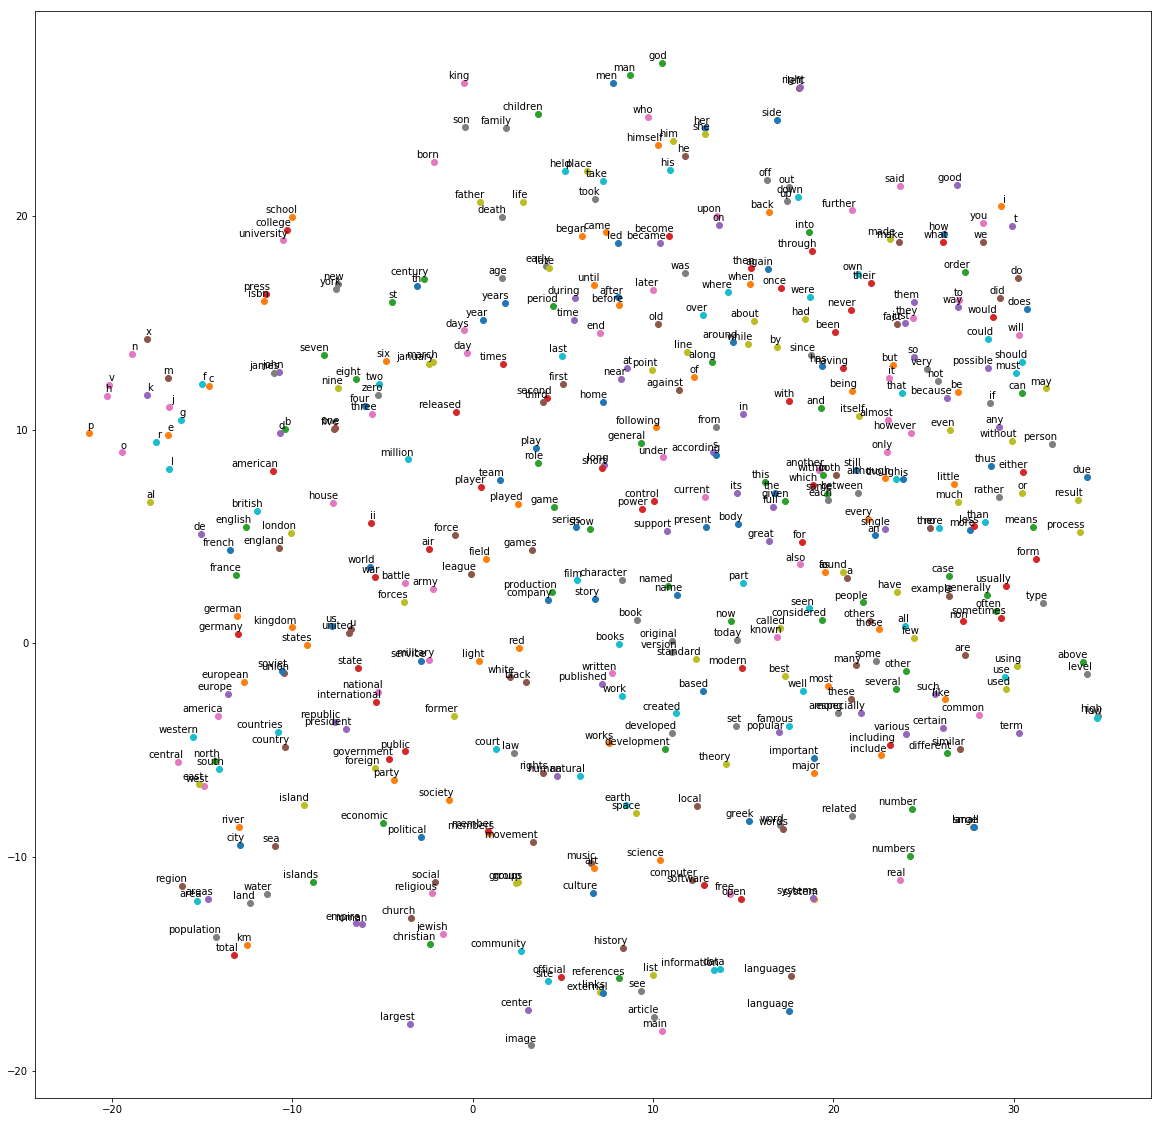

In [96]:
from matplotlib import pylab

%matplotlib inline

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

plot(two_d_embeddings, labels)